In [47]:
import pandas as pd
import numpy as np

# Load dataset (replace 'your_file.csv' with the actual file)
df = pd.read_csv("input.csv", parse_dates=["Timestamp"], index_col="Timestamp")

# Fill missing values (if any)
df.index = pd.DatetimeIndex(df.index)
df = df.resample('h').ffill().reset_index()  # Forward-fill method

# Visualize the first few rows
print(df.head())
print(df.index)


            Timestamp  GRT  ship_loa  power  Vehicle      wspd        wdir  \
0 2023-01-01 00:00:00    0       0.0    0.0      932  9.800000  222.833333   
1 2023-01-01 01:00:00    0       0.0    0.0     1038  8.983333  224.666667   
2 2023-01-01 02:00:00    0       0.0    0.0      809  8.050000  225.333333   
3 2023-01-01 03:00:00    0       0.0    0.0      630  7.033333  217.000000   
4 2023-01-01 04:00:00    0       0.0    0.0      403  7.983333  216.833333   

   Sensor_Temp  Sensor_Humidity     avg_CO2  CO2_1D1CF5  CO2_1D8BC5  \
0        15.60            71.05  392.707301  393.512581   396.21218   
1        15.15            68.95  392.407301  391.762581   396.71218   
2        14.80            69.10  391.657301  393.012581   399.71218   
3        14.80            70.00  392.207301  383.262581   401.71218   
4        14.60            70.60  393.757301  392.262581   397.71218   

   CO2_1D92BC  CO2_1D95D8  CO2_18E141  
0  398.960762  384.289442  390.561539  
1  395.960762  381.03944

In [48]:
# Define prediction target
target = "avg_CO2"

# Define feature set (excluding target and timestamp)
features = ['GRT', 'ship_loa', 'power', 'wdir', 'wspd', 'Sensor_Temp', 'Sensor_Humidity', 'Vehicle']

# Train-test split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 6566, Test size: 1642


In [50]:
from statsmodels.tsa.stattools import adfuller
result_original = adfuller(df[target])
print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

df['{}_Diff'.format(target)] = df[target].diff()
result_diff = adfuller(df["{}_Diff".format(target)].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")


ADF Statistic (Original): -7.8266
p-value (Original): 0.0000
Interpretation: The original series is Stationary.

ADF Statistic (Differenced): -23.2813
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


f:\LEONLAH\myprojects\hackpompey\data-model\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                avg_CO2   No. Observations:                 6566
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -20514.841
Date:                Sat, 29 Mar 2025   AIC                          41045.683
Time:                        06:37:10   BIC                          41099.999
Sample:                             0   HQIC                         41064.460
                               - 6566                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0155      0.020      0.793      0.428      -0.023       0.054
ar.L2          0.7813      0.020     39.601      0.000       0.743       0.820
ar.L3         -0.1939      0.008    -25.688      0.0

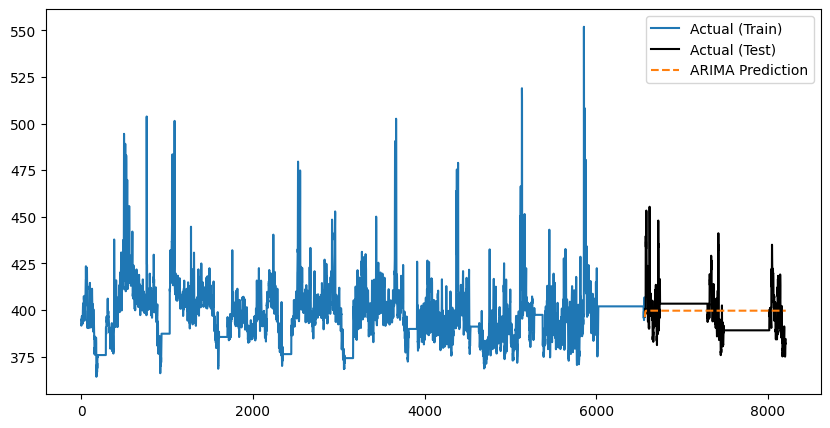

In [52]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# Train ARIMA model (AutoRegressive Integrated Moving Average)
# (p,d,q) values may need tuning
arima_model = ARIMA(train[target], order=(5, 1, 2))
arima_fit = arima_model.fit()
print(arima_fit.summary())

# Forecast using ARIMA
train.loc[:, ("arima_pred")] = arima_fit.fittedvalues
test.loc[:, ("arima_pred")] = arima_fit.forecast(steps=len(test))

# Plot ARIMA prediction
# pd.plotting.register_matplotlib_converters()

plt.figure(figsize=(10, 5))
# plt.xticks(ticks=range(0, len(df)), labels=df.index.to_pydatetime())
plt.plot(train[target], label="Actual (Train)")
plt.plot(test[target], label="Actual (Test)", color='black')
# plt.plot(train["arima_pred"], label="ARIMA Prediction", linestyle="dashed")
plt.plot(test["arima_pred"], label="ARIMA Prediction", linestyle="dashed")
plt.legend()
plt.show()

In [54]:
print(f"AIC: {arima_fit.aic}")
print(f"BIC: {arima_fit.bic}")

AIC: 41045.68283679879
BIC: 41099.99889909269


In [82]:
from sklearn.metrics import mean_squared_error

forecast = test.loc[:, ("arima_pred")][:len(test)]
test_forecast = test[target][:len(forecast)]

rmse = np.sqrt(mean_squared_error(test_forecast, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 10.4232


C:\Users\Leon-Inspiron\AppData\Local\Temp\ipykernel_8392\2673140044.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["residual"] = train[target] - train["arima_pred"]
C:\Users\Leon-Inspiron\AppData\Local\Temp\ipykernel_8392\2673140044.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["residual"] = test[target] - test["arima_pred"]
C:\Users\Leon-Inspiron\AppData\Local\Temp\ipykernel_8392\2673140044.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

6566    396.207686
6567    396.842199
6568    397.496701
6569    398.114526
6570    398.573624
           ...    
8203    399.692331
8204    399.692331
8205    399.692331
8206    399.692331
8207    399.692331
Name: arima_pred, Length: 1642, dtype: float64 6566   -0.038871
6567   -0.287119
6568   -0.330433
6569    0.627500
6570    1.169472
          ...   
8203   -1.588106
8204   -0.285381
8205   -0.139880
8206   -0.139880
8207   -0.318089
Name: xgb_pred_residual, Length: 1642, dtype: float32
MAE: 8.04, RMSE: 11.28


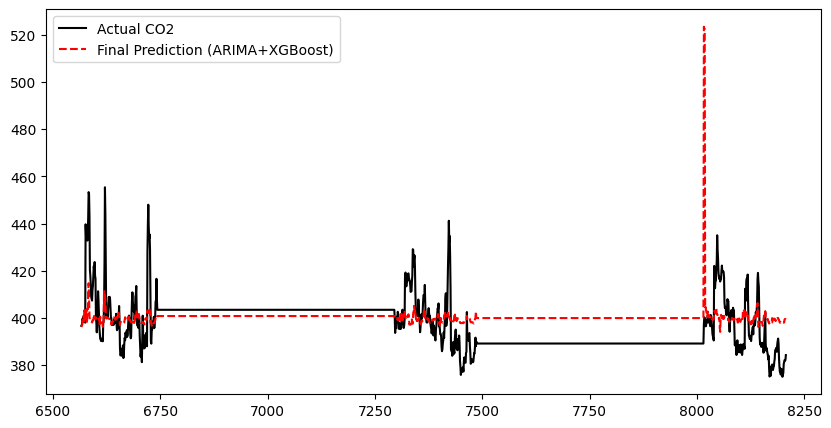

In [86]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use ARIMA residuals (error) as the new target for XGBoost
train["residual"] = train[target] - train["arima_pred"]
test["residual"] = test[target] - test["arima_pred"]

# Train XGBoost on feature set
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=5)

xgb_model.fit(train[features], train["residual"])

# Predict residuals using XGBoost
test["xgb_pred_residual"] = xgb_model.predict(test[features])

# Final prediction: ARIMA + XGBoost residual correction
test["final_pred"] = test["arima_pred"] + test["xgb_pred_residual"]

# print(test["arima_pred"], test["xgb_pred_residual"])

# Evaluate model
mae = mean_absolute_error(test[target], test["final_pred"])
rmse = np.sqrt(mean_squared_error(test[target], test["final_pred"]))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot Final Prediction
plt.figure(figsize=(10,5))
plt.plot(test[target], label="Actual CO2", color='black')
plt.plot(test["final_pred"], label="Final Prediction (ARIMA+XGBoost)", linestyle="dashed", color="red")
plt.legend()
plt.show()


In [85]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200, 25],
    "max_depth": [3, 5, 7, ],
    "learning_rate": [0.01, 0.1, 0.2, 0.00001]
}

xgb_grid = GridSearchCV(XGBRegressor(), param_grid, scoring="neg_mean_absolute_error", cv=3)
xgb_grid.fit(train[features], train["residual"])

print("Best XGBoost Parameters:", xgb_grid.best_params_)


Best XGBoost Parameters: {'learning_rate': 1e-05, 'max_depth': 3, 'n_estimators': 25}


In [87]:
import joblib

# Save the trained models
joblib.dump(arima_fit, "arima_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")

print("Models saved successfully!")


Models saved successfully!
